In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utilities import train_test_val_split, rmse, load_matlab_data
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
matlab_data = loadmat("data/hwk8data.mat")
print(matlab_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data', 'test1', 'test2'])


In [4]:
data = matlab_data['data']
test1 = matlab_data['test1']
test2 = matlab_data['test2']

In [5]:
print(data.shape)

(450, 21)


In [7]:
scale = StandardScaler().fit(data)

In [8]:
data_s = scale.transform(data)

In [9]:
pca = PCA().fit(data_s)

In [10]:
def t2(data, pca):
    """Calculate the T^2 score for a data sample
    """
    l = np.diag(pca.explained_variance_)
    t = pca.transform(data)
    return np.array([tt @ l @ tt.T for tt in t])

In [30]:
def q(data, pca):
    """Calculate Q-score for a data sample
    """
    # Get dimensionality of the data
    i = data.shape[1]
    
    pp = pca.components_.T @ pca.components_
    
    return np.array([x @ (np.eye(i) - pp) @ x.T for x in data])

In [31]:
test1_s = scale.transform(test1)
test2_s = scale.transform(test2)

Text(0.5, 1.0, '$T^2$ Scores')

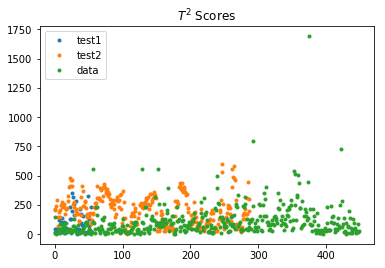

In [32]:
plt.plot(t2(test1_s, pca), '.', label="test1")
plt.plot(t2(test2_s, pca), '.', label="test2")
plt.plot(t2(data_s, pca), '.', label="data")
plt.legend(loc="upper left")
plt.title(r'$T^2$ Scores')

Text(0.5, 1.0, '$Q$ Scores')

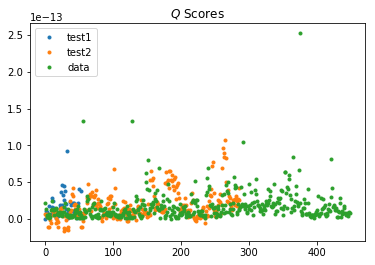

In [33]:
plt.plot(q(test1_s, pca), '.', label="test1")
plt.plot(q(test2_s, pca), '.', label="test2")
plt.plot(q(data_s, pca), '.', label="data")
plt.legend(loc="upper left")
plt.title(r'$Q$ Scores')

In [34]:
pca.n_components_

21

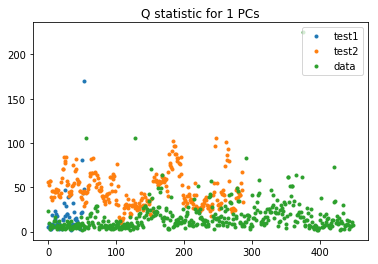

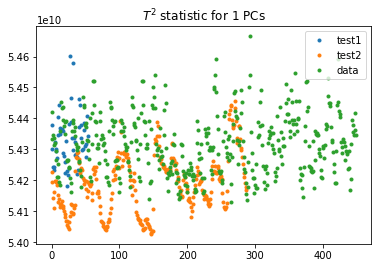

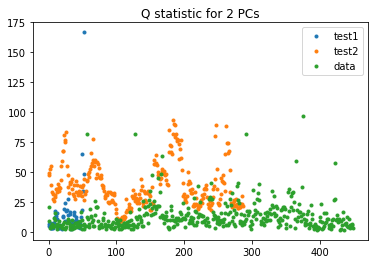

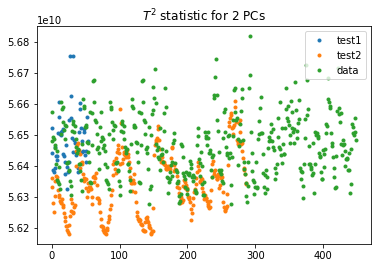

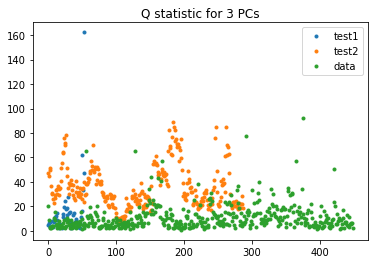

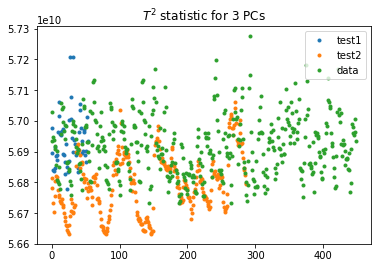

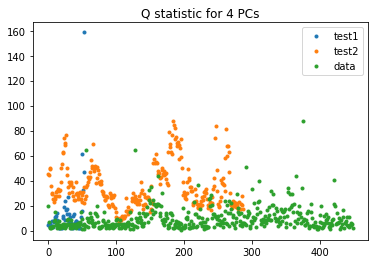

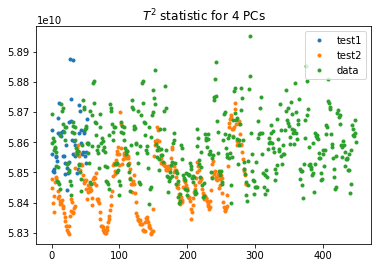

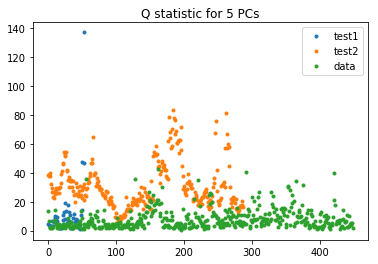

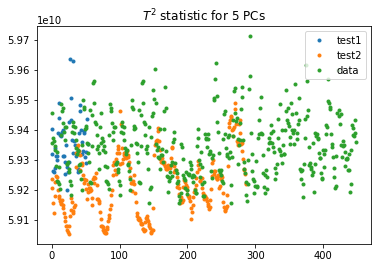

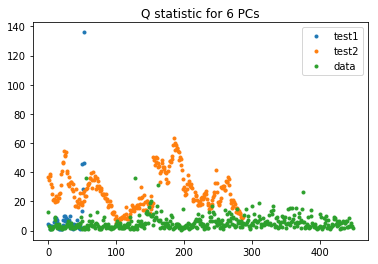

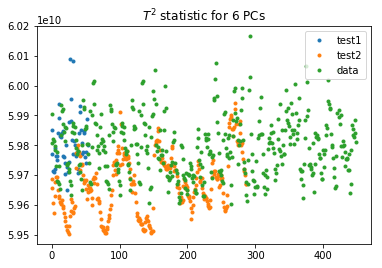

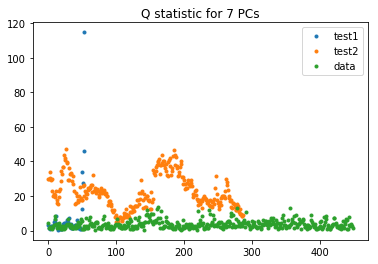

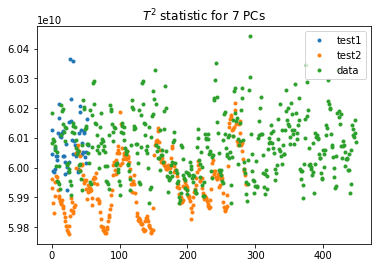

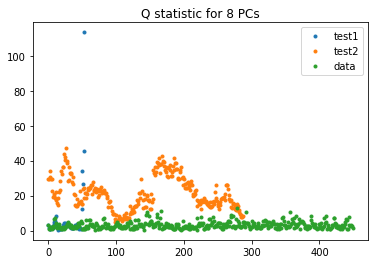

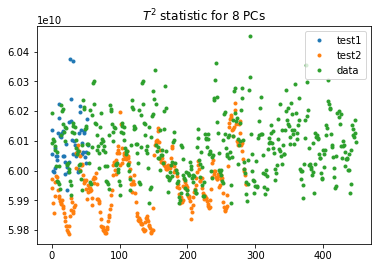

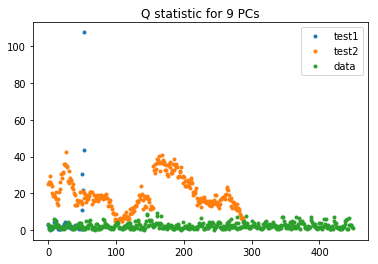

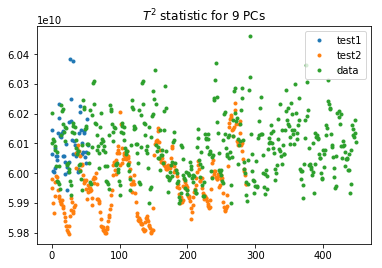

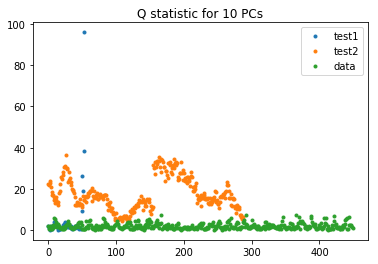

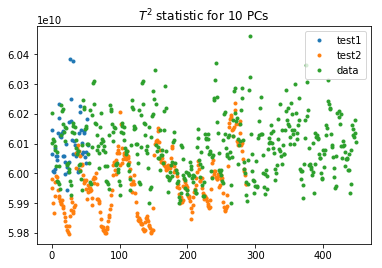

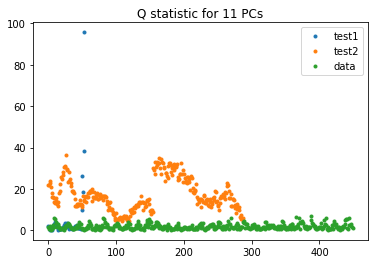

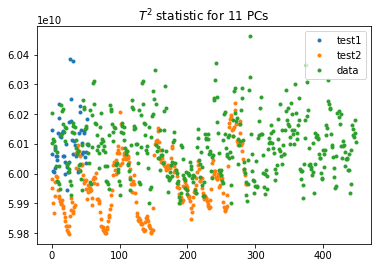

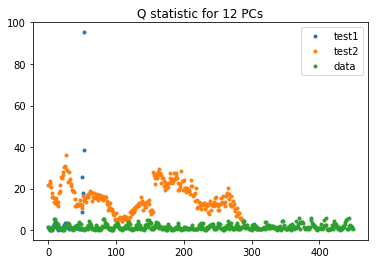

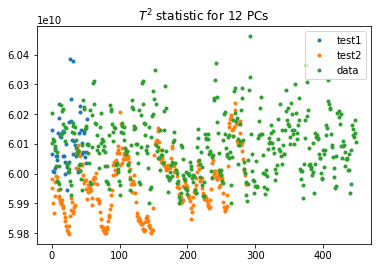

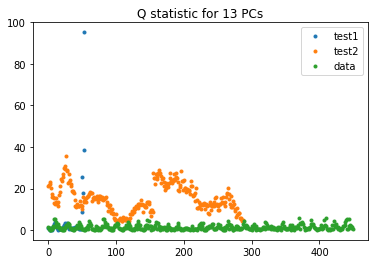

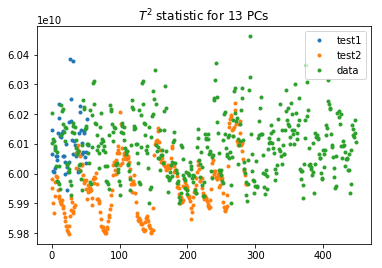

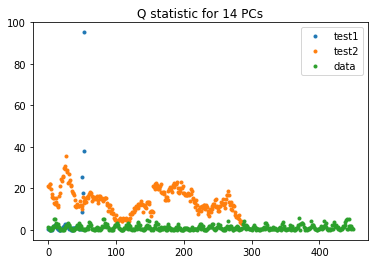

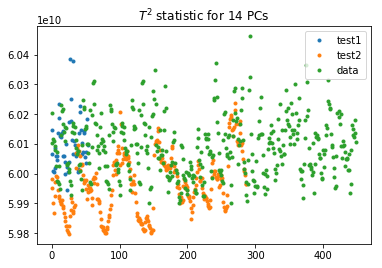

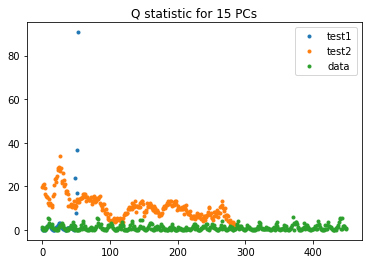

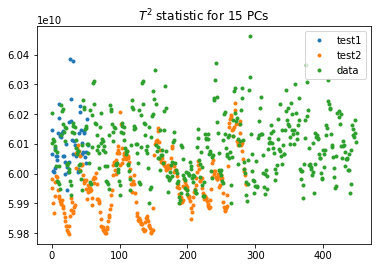

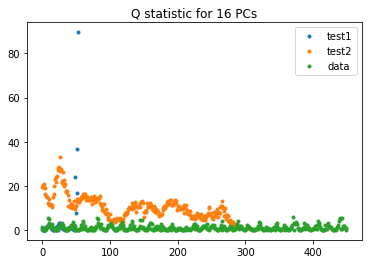

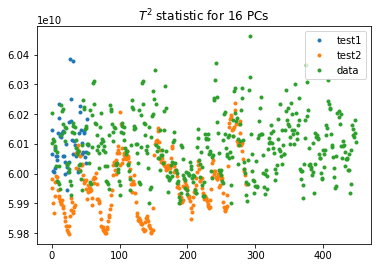

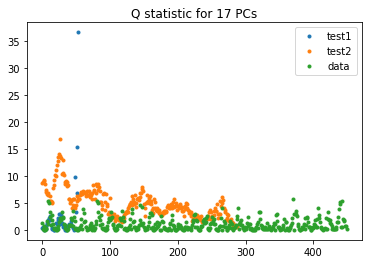

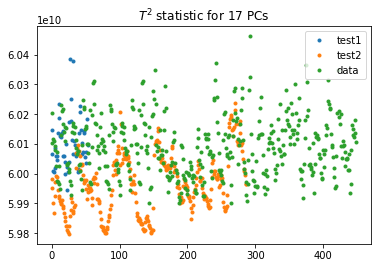

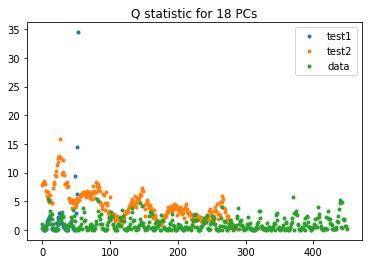

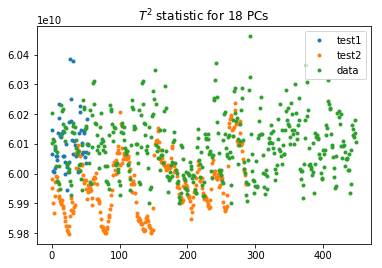

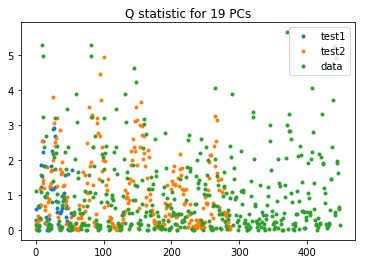

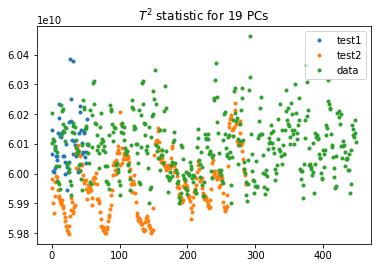

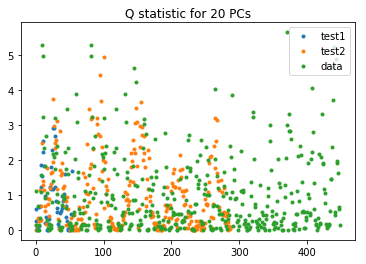

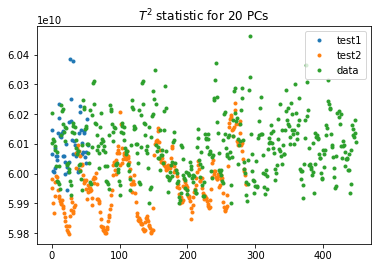

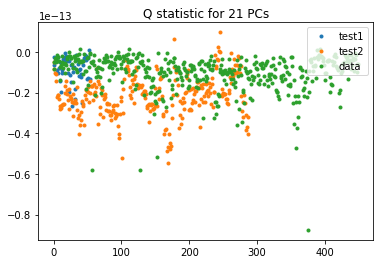

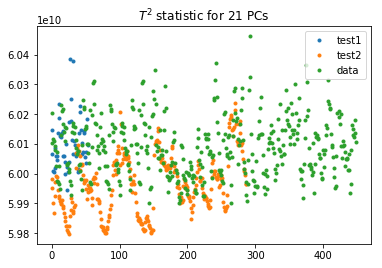

In [37]:
for i in range(1, 22):
    pca2 = PCA(n_components=i).fit(data)
    f = plt.figure()
    plt.plot(q(test1_s, pca2), '.', label="test1")
    plt.plot(q(test2_s, pca2), '.', label="test2")
    plt.plot(q(data_s, pca2), '.', label="data")
    plt.title(f"Q statistic for {i} PCs")
    plt.legend(loc="upper right")
    plt.show()
    f = plt.figure()
    plt.plot(t2(test1_s, pca2), '.', label="test1")
    plt.plot(t2(test2_s, pca2), '.', label="test2")
    plt.plot(t2(data_s, pca2), '.', label="data")
    plt.title(f"$T^2$ statistic for {i} PCs")
    plt.legend(loc="upper right")
    plt.show()

In [25]:
pca.components_.shape

(21, 21)

In [26]:
pca2 = PCA(n_components=2).fit(data_s)

In [28]:
pca2.components_.shape

(2, 21)

In [29]:
pca2.components_.T

array([[-0.24660903, -0.01641844],
       [-0.30275052, -0.05384745],
       [-0.31870942, -0.06590417],
       [-0.2938152 , -0.09968837],
       [-0.2924922 , -0.1737396 ],
       [-0.27043412, -0.23197742],
       [-0.24231561, -0.26982482],
       [-0.20481461, -0.29988702],
       [-0.1577057 , -0.3056017 ],
       [-0.08630837, -0.05537241],
       [ 0.21313416, -0.06604233],
       [ 0.24901829, -0.06473844],
       [ 0.24501323, -0.0934525 ],
       [ 0.24415936, -0.21499491],
       [ 0.21695929, -0.28819772],
       [ 0.18127827, -0.32363334],
       [ 0.15072396, -0.33841925],
       [ 0.14004533, -0.33457468],
       [ 0.13527444, -0.29374198],
       [-0.01717726, -0.0752524 ],
       [ 0.00336235, -0.26388301]])

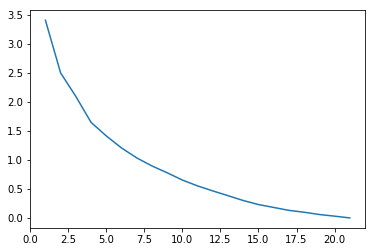

In [43]:
rs = []
for i in range(1, 22):
    pcat = PCA(n_components=i).fit(data_s)
    t = pcat.transform(data_s)
    ut = pcat.inverse_transform(t)
    residuals = la.norm(data_s - ut, axis=1)
    rs.append(np.mean(residuals))
plt.plot(range(1, 22), rs)

In [44]:
print(rs[-1])

5.005790417885659e-15
